In [1]:
from halotools.sim_manager import CachedHaloCatalog, FakeSim
from halotools.empirical_models import PrebuiltHodModelFactory, Zheng07Cens, Zheng07Sats, TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory
from halotools.mock_observables import return_xyz_formatted_array
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, cpu_count
import emcee
import corner
from Corrfunc.theory.wp import wp
import MCMC_data_file
from numpy.linalg import inv
import scipy.optimize as op
from scipy.stats import chi2
import scipy.stats as stats
import random
import MCMC_data_file, zehavi_data_file_20,zehavi_data_file_21,zehavi_data_file_19
import warnings
warnings.filterwarnings("ignore")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from scipy.special import gamma

In [3]:
dname = "zehavi_data_file_20"
if '21' in dname:
    wp_ng_vals = zehavi_data_file_21.get_wp()[0:12]
    bin_edges = zehavi_data_file_21.get_bins()[0:12]
    cov_matrix = zehavi_data_file_21.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '20' in dname:
    wp_ng_vals = zehavi_data_file_20.get_wp()[0:12]
    bin_edges = zehavi_data_file_20.get_bins()[0:12]
    cov_matrix = zehavi_data_file_20.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if '19' in dname:
    wp_ng_vals = zehavi_data_file_19.get_wp()[0:12]
    bin_edges = zehavi_data_file_19.get_bins()[0:12]
    cov_matrix = zehavi_data_file_19.get_cov()[0:11,0:11]
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])    
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if 'guo' in dname:
    wp_ng_vals = guo_data_file.get_wp()
    bin_edges = guo_data_file.get_bins()
    cov_matrix = guo_data_file.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.
if 'mock' in dname:
    wp_ng_vals = mock_data_2.get_wp()
    bin_edges = mock_data_2.get_bin_edges()
    cov_matrix = mock_data_2.get_cov()
    err = np.array([cov_matrix[i,i] for i in range(len(cov_matrix))])
    bin_cen = (bin_edges[1:]+bin_edges[:-1])/2.

In [61]:
m=np.load('zehavi_smdpl_mvir_m19_wp.npy')
v=np.load('zehavi_smdpl_vmax_m19_wp.npy')

In [4]:
def calc_chi2(obs,exp,var):
    chi2s = []
    for wp in obs:
        diff = wp-exp
        chi2 = np.sum(diff**2/var)
        chi2s.append(round(chi2,7))
        
    return chi2s

In [63]:
chi2s = calc_chi2(m['wp'],wp_ng_vals[1:12],err)
m_row_min = np.where(chi2s == np.min(chi2s))
m_row_max = np.where(chi2s == np.max(chi2s))

In [64]:
mwp_vmax = np.zeros(11)
ewp_vmax = np.zeros(11)
mwp_mvir = np.zeros(11)
ewp_mvir = np.zeros(11)
for i in range(11): 
    sv = []
    sm = []
    for j in range(10):
        sv.append(v['wp'][j][i])
        sm.append(m['wp'][j][i])
    mwp_vmax[i]+=np.mean(sv)
    mwp_mvir[i]+=np.mean(sm)
    ewp_vmax[i]+=np.std(sv)
    ewp_mvir[i]+=np.std(sm)

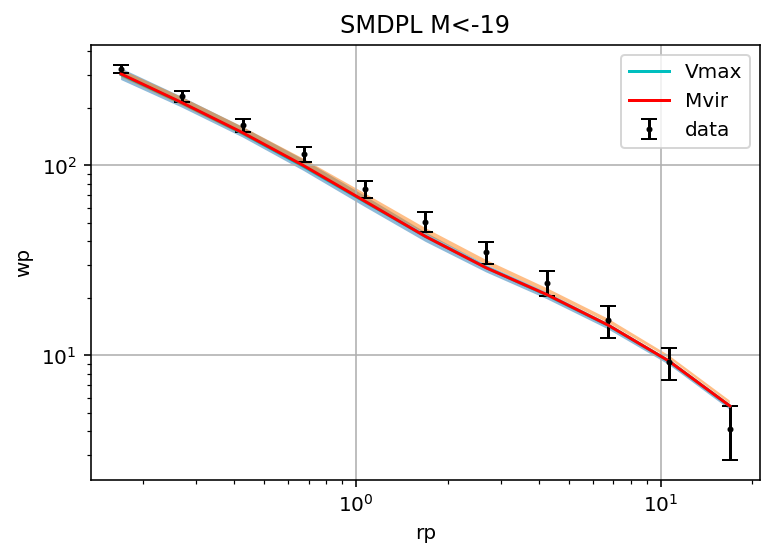

In [66]:
plt.errorbar(bin_cen,wp_ng_vals[1:len(wp_ng_vals)],yerr=np.sqrt(err),fmt='o',
             markersize=2,capsize=4,label='data',c='k')
plt.plot(bin_cen,mwp_vmax,markersize=2,label='Vmax',c='c')
plt.plot(bin_cen,mwp_mvir,markersize=2,label='Mvir',c='r')
#plt.fill_between(bin_cen, mwp_vmax-ewp_vmax, mwp_vmax+ewp_vmax,alpha='0.5')
#plt.fill_between(bin_cen, mwp_mvir-ewp_mvir, mwp_mvir+ewp_mvir,alpha='0.5')
plt.fill_between(bin_cen, m['wp'][m_row_min][0], m['wp'][m_row_max][0],alpha='0.5')
plt.fill_between(bin_cen, v['wp'][v_row_min][0], v['wp'][v_row_max][0],alpha='0.5')
plt.title("SMDPL M<-19")
plt.legend()
plt.ylabel('wp')
plt.xlabel('rp')
plt.tick_params()
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.show()

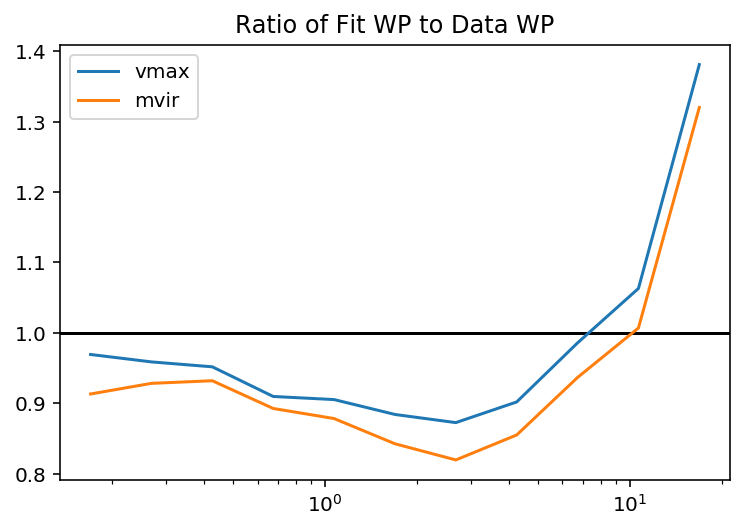

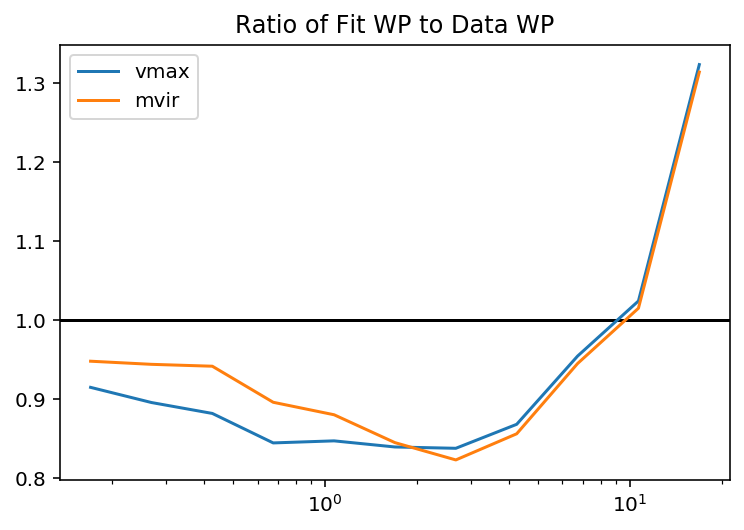

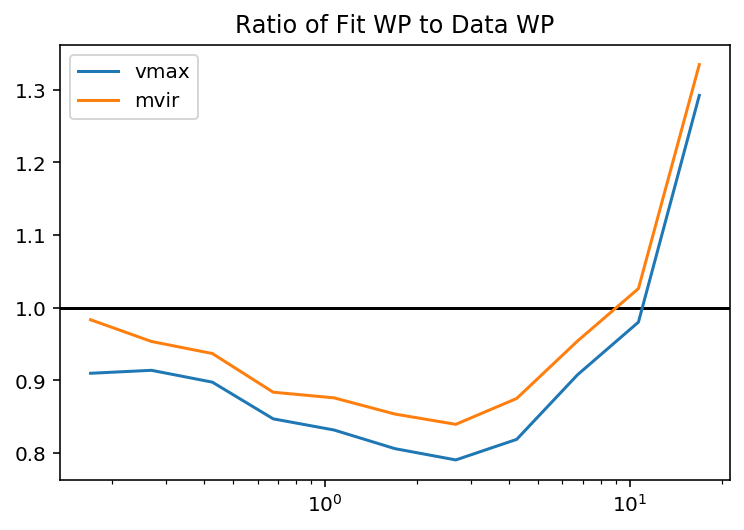

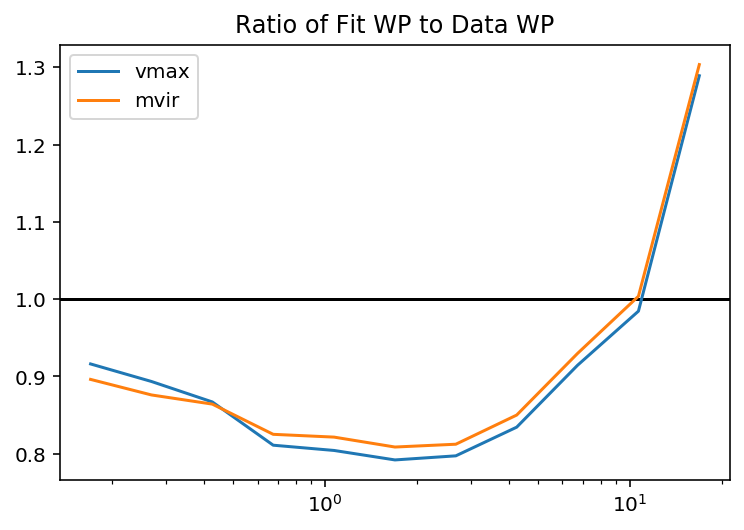

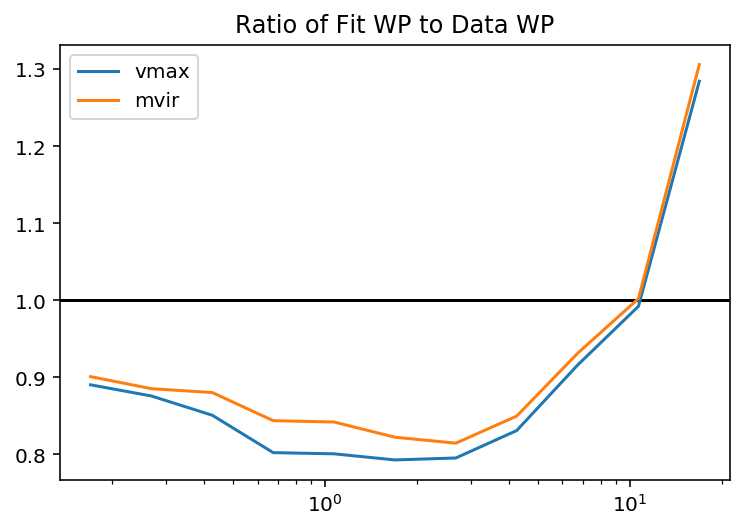

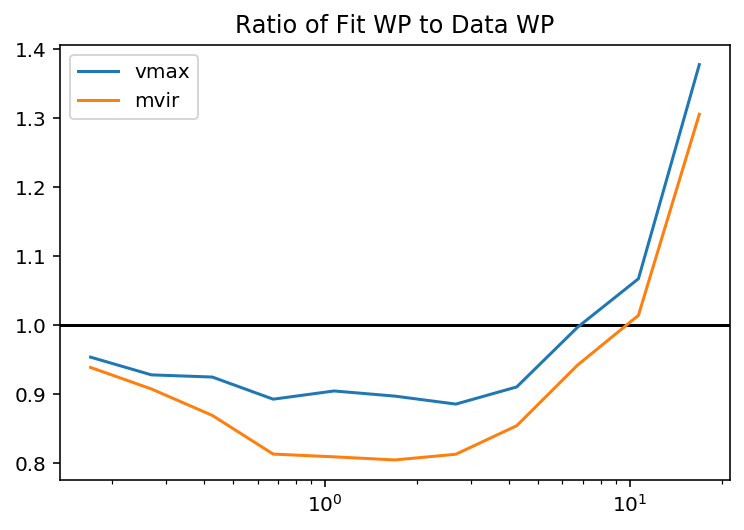

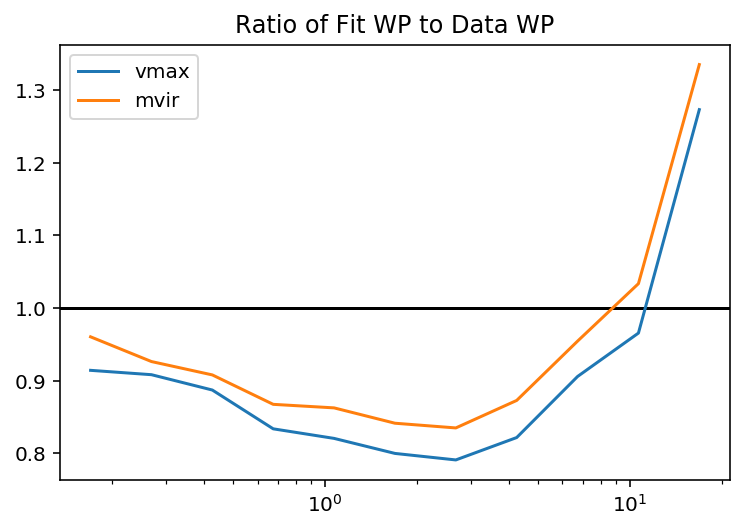

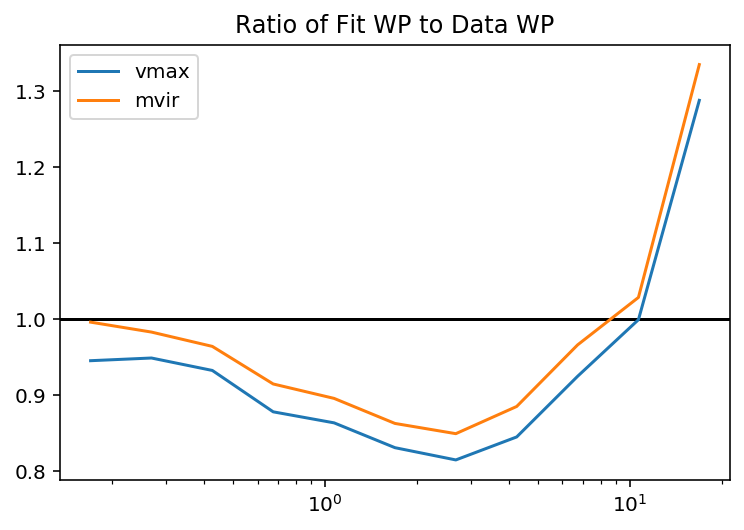

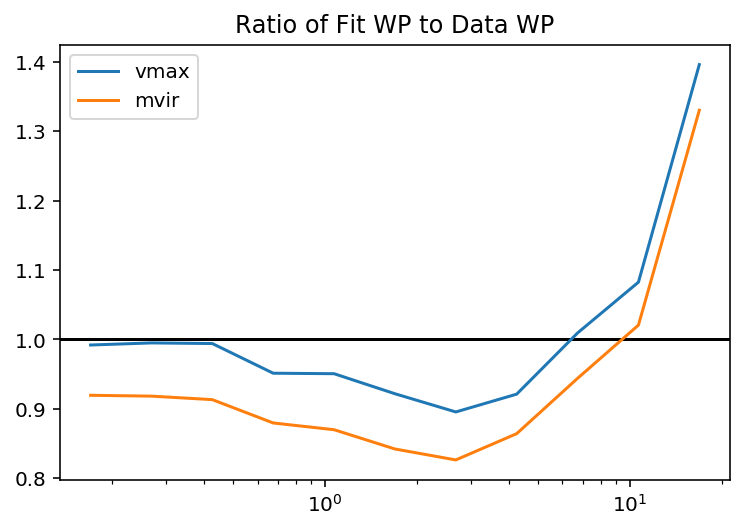

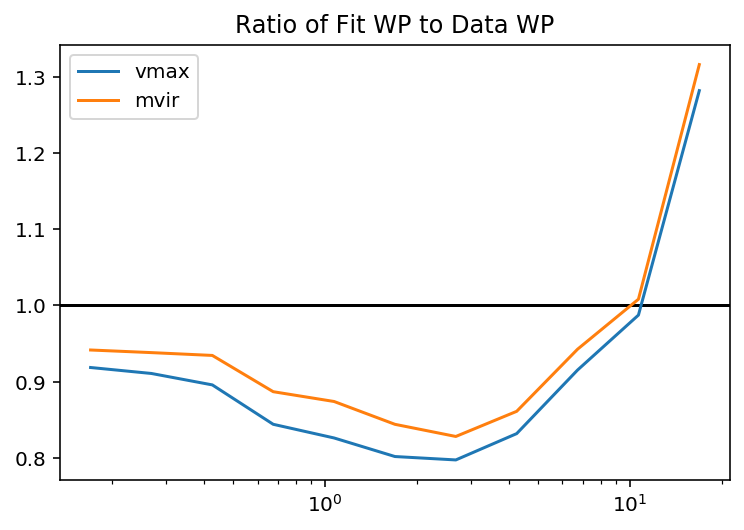

In [67]:
vmax_ratio = v['wp']/wp_ng_vals[1:len(wp_ng_vals)]
mvir_ratio = m['wp']/wp_ng_vals[1:len(wp_ng_vals)]

for i in range(10):
    plt.axhline(1,c='black')
    plt.plot(bin_cen,vmax_ratio[i],label='vmax')
    plt.plot(bin_cen,mvir_ratio[i],label='mvir')
    plt.xscale('log')
    plt.title('Ratio of Fit WP to Data WP')
    plt.legend()
    plt.show()

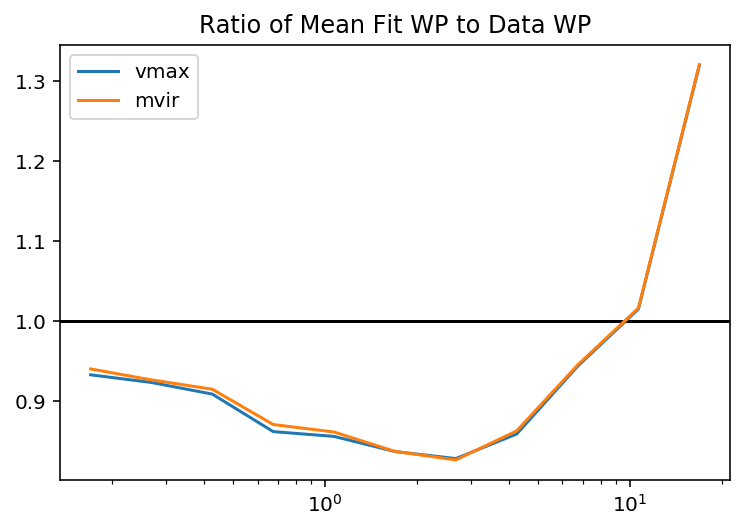

In [68]:
plt.axhline(1,color='black')
plt.plot(bin_cen,mwp_vmax/wp_ng_vals[1:len(wp_ng_vals)],label='vmax')
plt.plot(bin_cen,mwp_mvir/wp_ng_vals[1:len(wp_ng_vals)],label='mvir')
plt.xscale('log')
plt.title('Ratio of Mean Fit WP to Data WP')
plt.legend()
plt.show()

# Chi2 Analysis

In [88]:
v = np.load('zehavi_smdpl_vmax_m20_top50wp.npy')
m = np.load('zehavi_smdpl_mvir_m20_top50wp.npy')

In [89]:
v_mean_wp = []
m_mean_wp = []
for i in range(50):
    v_mean_wp.append(np.mean(v[i],axis=0))
    m_mean_wp.append(np.mean(m[i],axis=0))

In [90]:
v_avg_chi2s = []
v_avg_chi2s.append(calc_chi2(v_mean_wp,wp_ng_vals[1:12],err))
m_avg_chi2s = []
m_avg_chi2s.append(calc_chi2(m_mean_wp,wp_ng_vals[1:12],err))

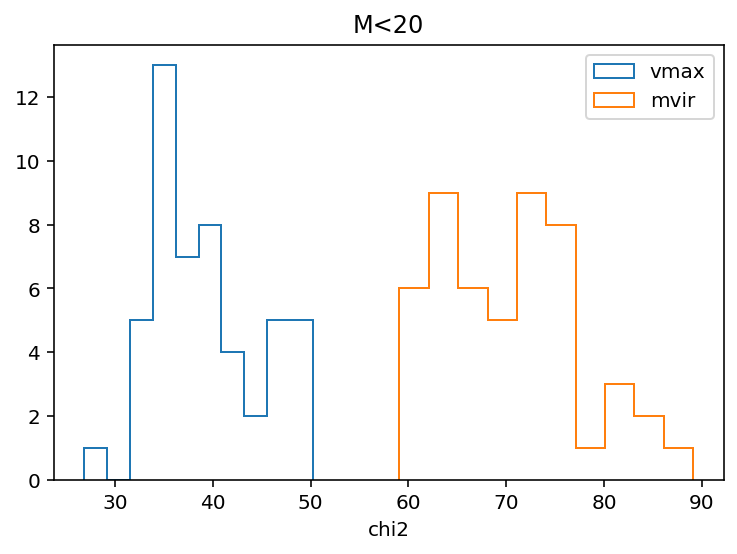

In [91]:
#bins = np.linspace(0,30,25)
#bins = 15
plt.hist(v_avg_chi2s,histtype='step', label='vmax')
plt.hist(m_avg_chi2s,histtype='step', label='mvir')
#plt.hist(calc_chi2(v[:,0,:],wp_ng_vals[1:12],err),histtype='step',bins=bins)
plt.xlabel('chi2')
plt.legend()
plt.title('M<20')
plt.show()

(1, 50)
